In [ ]:
!pip3 install pydicom
!pip3 install pyransac3d

In [ ]:
!pip install scikit-fda

In [ ]:
!pip install pyclustering

In [ ]:
!pip install yellowbrick

In [1]:
import PIL
import pydicom
from PIL import Image
import numpy as np
import cv2
import os
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import math

In [2]:
import matplotlib.pyplot as plt

In [3]:
import open3d as o3d

In [4]:
import pyransac3d as pyrsc
from sklearn.cluster import KMeans,OPTICS,DBSCAN
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

In [5]:
import natsort 

In [6]:
def num_to_rgb(val, max_val=49):
    i = (val * 255 / max_val);
    r = abs(math.sin(0.024 * i + 0));
    g = abs(math.sin(0.024 * i + 2));
    b = abs(math.sin(0.024 * i + 4));
    return [r,g,b]

In [7]:
import pandas as pd
df=pd.DataFrame(pd.read_csv("archive/bags_train.csv"))
patientd_dcm=list(df[df["bag_name"] == "ID_04ef429610"]["instance_name"])
file_path = "archive/Brain_CT_data/train/"

In [8]:
patient_dicoms = [ pydicom.dcmread(file_path+name) for name in patientd_dcm]
positions = [float(patient_dicoms[i].ImagePositionPatient[-1]) for i in range(len(patient_dicoms))]
sorted_dicoms = [patient_dicoms for _,patient_dicoms in sorted(zip(positions,patient_dicoms))]

In [9]:
arrays_without_windowing = np.array([ dicom.pixel_array for dicom in sorted_dicoms])

In [10]:
intercept = patient_dicoms[30].RescaleIntercept
slope = patient_dicoms[30].RescaleSlope

In [11]:
rescaled_to_hu_values = arrays_without_windowing*slope +intercept

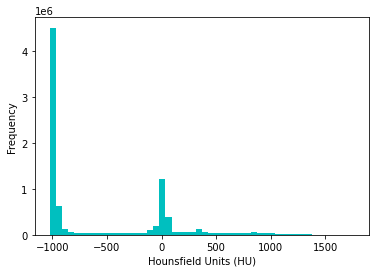

In [12]:
plt.hist(rescaled_to_hu_values.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


In [13]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img

In [14]:
brain_view_dicoms = np.array([ window_image(img, 40, 80, intercept, slope) for img in arrays_without_windowing])

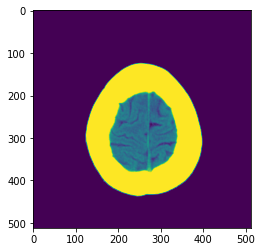

In [15]:
plt.imshow(brain_view_dicoms[25])

In [85]:
z, x, y = brain_view_dicoms.nonzero()
# downsample points , get every 30
x, y, z = x[::30],y[::30], z[::30]
# get hu_values for every pouint
hu_values = brain_view_dicoms[z, x, y]

In [86]:
cl = np.zeros((np.size(hu_values),3))
norm_colors = (hu_values - hu_values.min()) / (hu_values.max() - hu_values.min())
cl[:, 0] = np.reshape(norm_colors, -1)
cl[:, 1] = np.reshape(norm_colors, -1)
cl[:, 2] = np.reshape(norm_colors, -1)           

In [37]:
xyz = np.zeros((np.size(y),3))
xyz[:, 0] = np.reshape(x, -1)
xyz[:, 1] = np.reshape(y, -1)
xyz[:, 2] = np.reshape(z, -1)
pcd = o3d.geometry.PointCloud()
pcd.colors = o3d.utility.Vector3dVector(cl)
pcd.points = o3d.utility.Vector3dVector(xyz)

In [38]:
o3d.visualization.draw_geometries([pcd])

In [23]:
def get_eugen_stats(data):
    centered_data = data - np.mean(data, axis=1)[:, None]
    covar = np.cov(centered_data)
    eigen_vals, eigen_vecs = np.linalg.eig(covar)
    eigen_vals, eigen_vecs = np.real(eigen_vals), np.real(eigen_vecs)
    normal_1 = eigen_vecs[0, 2]
    normal_2 = eigen_vecs[1, 2]
    normal_3 = eigen_vecs[2, 2]
    curvative = eigen_vals[0] / ( eigen_vals[0] + eigen_vals[1] + eigen_vals[2] ) 
    linearity = ( eigen_vals[1] - eigen_vals[2] ) / eigen_vals[1]
    return normal_1,normal_2,normal_3, curvative,linearity

In [24]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd)

In [25]:
# compute basic features
features = np.zeros((np.size(y),14))
features[:, 0] = np.reshape(x, -1)
features[:, 1] = np.reshape(y, -1)
features[:, 2] = np.reshape(z, -1)
features[:, 3] = np.reshape(hu_values, -1)

In [ ]:
for i in range(np.size(y)):
    print(i)
    #find nearest neighbors in sphere of radius 10
    [k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[i], 10)
    indeces=np.array(idx)
    if len(indeces) > 2:
        normal_1,normal_2,normal_3, curvative,linearity =get_eugen_stats(features[indeces])
        features[i,4] = max(features[indeces,3])
        features[i,5] = min(features[indeces,3])
        features[i,6] = features[indeces,3].mean()
        features[i,7] = features[indeces,3].std()
        features[i,8] = normal_1
        features[i,9] = normal_2
        features[i,10] = normal_3
        features[i,11] = curvative
        features[i,12] = linearity
        features[i,13] = len(features[indeces])
    
    
    

In [27]:
# standatize new features
scaler = preprocessing.StandardScaler().fit(features)
transformed_features = scaler.transform(features)

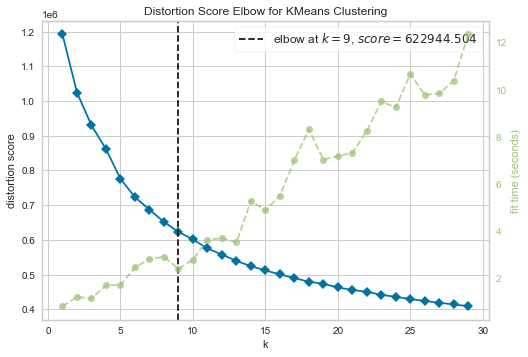

In [170]:
from yellowbrick.cluster import KElbowVisualizer # cluster visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1, 30))
visualizer.fit(transformed_features) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

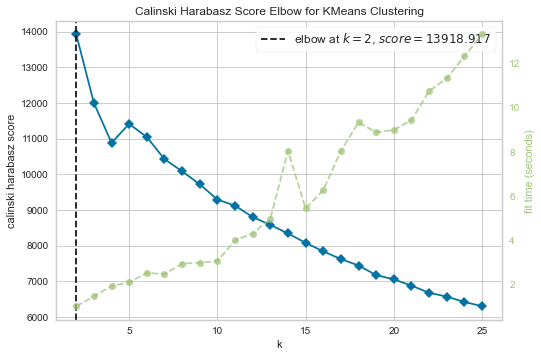

In [175]:
visualizer = KElbowVisualizer(model, k=25,metric='calinski_harabasz')
visualizer.fit(transformed_features) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [176]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [228]:
centers = kmeans_plusplus_initializer(transformed_features, 9).initialize()

In [302]:
kmeans_instance = kmeans(transformed_features, centers,metric=distance_metric(3));
# Run clustering process and obtain result.
kmeans_instance.process();

In [303]:
pyCenters = kmeans_instance.get_centers()
pyClusters = kmeans_instance.get_clusters()
pyEncoding = kmeans_instance.get_cluster_encoding()
pyEncoder = cluster_encoder(pyEncoding, pyClusters, transformed_features)
pyLabels = pyEncoder.set_encoding(0).get_clusters()
pyLabels=np.array(pyLabels)

In [304]:
cl = np.zeros((np.size(pyLabels),3))
colors = pyLabels
colors = [ num_to_rgb(color) for color in colors]

In [305]:
# create basic point cloud
xyz = np.zeros((np.size(y),3))
xyz[:, 0] = np.reshape(x, -1)
xyz[:, 1] = np.reshape(y, -1)
xyz[:, 2] = np.reshape(z, -1)

In [306]:
# to open3d format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(colors)
#voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
#                                                            voxel_size=0.1)
#o3d.visualization.draw_geometries([voxel_grid])

In [307]:
o3d.visualization.draw_geometries([pcd])

In [308]:
cl = np.zeros((np.size(hu_values),3))
norm_colors = (hu_values - hu_values.min()) / (hu_values.max() - hu_values.min())
cl[:, 0] = np.reshape(norm_colors, -1)
cl[:, 1] = np.reshape(norm_colors, -1)
cl[:, 2] = np.reshape(norm_colors, -1)           

In [309]:
cl[np.where(pyLabels== 8)] = np.array(colors)[pyLabels==8]

In [310]:
# visualize
pcd_class = o3d.geometry.PointCloud()
pcd_class.points = o3d.utility.Vector3dVector(xyz)
pcd_class.colors = o3d.utility.Vector3dVector(cl)
o3d.visualization.draw_geometries([pcd_class])
#vis = o3d.visualization.Visualizer()
#vis.create_window()
#vis.add_geometry(pcd_class)
#vis.capture_screen_image("file.jpg", do_render=True)
#vis.destroy_window()

In [301]:
point_cloud_dict = dict(x=x, y=y, z=z, colors=colors)

In [367]:
def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=1, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )